## Notebook 4: Análisis y Visualización de Resultados
 
**Objetivo:** Cargar los resultados para ambas vertientes (unidades y guaraníes), generar tablas de resumen y crear los gráficos 'lollipop' comparativos para cada análisis.
 
**Fases:**
1.  **Configuración:** Importar librerías y funciones.
2.  **Bucle de Análisis:** Iterar sobre 'cantidad' y 'monto_venta'.
    a. Cargar los resultados de la vertiente correspondiente.
    b. Generar y guardar las tablas de resumen.
    c. Generar y guardar el gráfico 'lollipop'.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# =============================================================================
# CELDA 1: IMPORTACIONES Y CONFIGURACIÓN
# =============================================================================

import pandas as pd
import numpy as np
import os
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from dbfread import DBF # <-- ¡NUEVO! Para leer el DBF

# Configurar logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
print("Librerías importadas y logging configurado.")

# --- Configuración de Matplotlib para la Tesis ---
try:
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "figure.titlesize": 18
    })
    print("Configuración de Matplotlib para 'Times New Roman' aplicada.")
except:
    print("Advertencia: No se pudo configurar la fuente 'Times New Roman'. Usando 'serif' por defecto.")

Librerías importadas y logging configurado.
Configuración de Matplotlib para 'Times New Roman' aplicada.


In [3]:
# =============================================================================
# CELDA 2: PARÁMETROS (¡Etiquetar esta celda como 'parameters' en Jupyter!)
# =============================================================================
# Papermill sobrescribirá estos valores
BASE_DIR = '..'
target_variable = 'all' # 'cantidad', 'monto_venta', o 'all'
datasets_to_run = ['F_48_NP'] # ¡ENFOCADO! Solo corremos F_48_NP
models_to_run = ['Lineal', 'Cuadrático', 'KNN', 'SARIMA']
metrics_to_calculate = ['R2', 'MAE', 'RMSE', 'MASE', 'ME']
maxiter = 50 # No se usa aquí, pero se recibe de main.py

# --- ¡Parámetros Clave para ESTE Notebook! ---
MAIN_METRIC = 'MASE' 
METRIC_THRESHOLD = 1.0
METRIC_COMPARISON = 'less_than'

print(f"Análisis configurado para la métrica principal: {MAIN_METRIC}")
print(f"Umbral de éxito: {MAIN_METRIC} {METRIC_COMPARISON.replace('_', ' ')} {METRIC_THRESHOLD}")
print(f"Datasets a analizar: {datasets_to_run}")

Análisis configurado para la métrica principal: MASE
Umbral de éxito: MASE less than 1.0
Datasets a analizar: ['F_48_NP']


In [4]:
# =============================================================================
# CELDA 3: CONFIGURACIÓN DE RUTAS E IMPORTACIÓN DE UTILS (v20 - ACTUALIZADA)
# =============================================================================
# Añadir utils al path
utils_path = os.path.join(BASE_DIR, '03_Code', 'utils')
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Importar las funciones *actualizadas* de nuestro motor
try:
    from utils.utils import (
        # Funciones de Carga (¡NUEVAS!)
        load_cv_results,
        load_universo_relevante_counts,
        get_total_product_universe,
        # Funciones de Resumen
        generar_resumenes_cv,
        # Funciones de Ploteo (¡ACTUALIZADAS!)
        plot_mapa_embudo_pie,
        plot_zoom_clasificacion_pie,
        plot_ganadores_barplot,
        plot_mase_distribution,
        plot_sesgo_boxplot,
        plot_risk_ratio_boxplot,
        plot_r2_distribution_boxplot
    )
    print("Funciones de análisis y visualización importadas desde utils.py.")
except ImportError as e:
    print(f"ERROR: No se pudieron importar las funciones desde utils.py: {e}")

# --- Rutas Corregidas ---
RAW_DATA_DIR = os.path.join(BASE_DIR, '02_Data', '01_Raw') # Para leer el total (in-f01.DBF)
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, '02_Data', '02_Processed') # Para leer conteos relevantes
RESULTS_DIR = os.path.join(BASE_DIR, '04_Resultados')
TABLES_INPUT_DIR = os.path.join(RESULTS_DIR, '01_Tablas_Detalladas') 
TABLES_OUTPUT_DIR = os.path.join(TABLES_INPUT_DIR, 'analisis_resultados')
FIGURES_OUTPUT_DIR = os.path.join(RESULTS_DIR, '02_Figuras', 'analisis_resultados')

os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)
os.makedirs(TABLES_OUTPUT_DIR, exist_ok=True)

logging.info(f"Directorio de Datos Crudos (Lectura): {RAW_DATA_DIR}")
logging.info(f"Directorio de Datos Procesados (Lectura): {PROCESSED_DATA_DIR}")
logging.info(f"Directorio de Tablas (Lectura): {TABLES_INPUT_DIR}")
logging.info(f"Directorio de Tablas (Escritura): {TABLES_OUTPUT_DIR}")
logging.info(f"Directorio de Figuras (Escritura): {FIGURES_OUTPUT_DIR}")

2025-11-11 14:35:08,242 - INFO - Directorio de Datos Crudos (Lectura): ..\02_Data\01_Raw
2025-11-11 14:35:08,242 - INFO - Directorio de Datos Procesados (Lectura): ..\02_Data\02_Processed
2025-11-11 14:35:08,243 - INFO - Directorio de Tablas (Lectura): ..\04_Resultados\01_Tablas_Detalladas
2025-11-11 14:35:08,243 - INFO - Directorio de Tablas (Escritura): ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados
2025-11-11 14:35:08,245 - INFO - Directorio de Figuras (Escritura): ..\04_Resultados\02_Figuras\analisis_resultados


Funciones de análisis y visualización importadas desde utils.py.


In [5]:
# =============================================================================
# CELDA 4: BUCLE PRINCIPAL DE ANÁLISIS (ORQUESTACIÓN) - (v20)
# =============================================================================
# Estos diccionarios guardarán TODOS los datos para las celdas posteriores
all_loaded_results = {}
all_summary_tables = {}
all_previsibilidad_data = {}
all_sesgo_dfs = {}

# Determinar los targets a procesar
if isinstance(target_variable, list):
    targets_a_procesar = target_variable
elif target_variable == 'all':
    targets_a_procesar = ['cantidad', 'monto_venta']
else:
    targets_a_procesar = [target_variable]

# --- ¡MODIFICADO! Obtener el universo total de productos (desde utils) ---
TOTAL_UNIVERSO_PRODUCTOS = get_total_product_universe(RAW_DATA_DIR)
if TOTAL_UNIVERSO_PRODUCTOS == 0:
    print("ADVERTENCIA: No se pudo leer el N=11596. El gráfico de torta usará un total de 0.")


for target in targets_a_procesar:
    display(Markdown(f"# Análisis Principal para: {target.upper()}"))
    
    # --- 1. Cargar Datos (desde utils) ---
    resultados_completos = load_cv_results(TABLES_INPUT_DIR, datasets_to_run, target)
    all_loaded_results[target] = resultados_completos
    
    if not resultados_completos:
        logging.warning(f"No se encontraron resultados para {target}. Saltando al siguiente target.")
        continue

    # --- 2. Generar Tablas Resumen (usando utils.py) ---\n",
    display(Markdown(f"## 1. Tablas Resumen de Modelos Ganadores ({target.upper()})"))
    
    df_total, df_filtrado = generar_resumenes_cv(
        resultados_completos,
        main_metric=MAIN_METRIC,
        threshold=METRIC_THRESHOLD,
        comparison_op=METRIC_COMPARISON
    )
    
    all_summary_tables[target] = {'total': df_total, 'filtrado': df_filtrado}

    display(Markdown(f"### Ganadores Totales (todos los productos modelados)"))
    display(df_total)
    path_total = os.path.join(TABLES_OUTPUT_DIR, f'resumen_ganadores_TOTAL_{target}_CV.csv')
    df_total.to_csv(path_total)
    print(f"Tabla resumen total guardada en: {path_total}")

    display(Markdown(f"### Ganadores Predictivos ({MAIN_METRIC} {METRIC_COMPARISON.replace('_', ' ')} {METRIC_THRESHOLD})"))
    display(df_filtrado)
    path_filtrado = os.path.join(TABLES_OUTPUT_DIR, f'resumen_ganadores_FILTRADOS_{target}_CV_{MAIN_METRIC}.csv')
    df_filtrado.to_csv(path_filtrado)
    print(f"Tabla resumen filtrada guardada en: {path_filtrado}")
    
    print("\nLógica de gráfico Lollipop omitida (según el nuevo enfoque de análisis).")

2025-11-11 14:35:10,464 - INFO - Universo total de productos (de in-f01.DBF): 11596


# Análisis Principal para: CANTIDAD

2025-11-11 14:35:10,471 - INFO - Iniciando carga de resultados para el target: CANTIDAD
2025-11-11 14:35:10,480 - INFO -  - Archivo cargado: resultados_detallados_F_48_NP_cantidad_CV.csv (Productos: 1044)


## 1. Tablas Resumen de Modelos Ganadores (CANTIDAD)

Tablas resumen generadas usando 'MASE' como métrica principal.


### Ganadores Totales (todos los productos modelados)

,F_48_NP
Modelo,
KNN,446
Lineal,289
SARIMA,266
Cuadrático,43


Tabla resumen total guardada en: ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados\resumen_ganadores_TOTAL_cantidad_CV.csv


### Ganadores Predictivos (MASE less than 1.0)

,F_48_NP
Modelo,
KNN,347
SARIMA,214
Lineal,198
Cuadrático,33


Tabla resumen filtrada guardada en: ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados\resumen_ganadores_FILTRADOS_cantidad_CV_MASE.csv

Lógica de gráfico Lollipop omitida (según el nuevo enfoque de análisis).


# Análisis Principal para: MONTO_VENTA

2025-11-11 14:35:10,513 - INFO - Iniciando carga de resultados para el target: MONTO_VENTA
2025-11-11 14:35:10,525 - INFO -  - Archivo cargado: resultados_detallados_F_48_NP_monto_venta_CV.csv (Productos: 1048)


## 1. Tablas Resumen de Modelos Ganadores (MONTO_VENTA)

Tablas resumen generadas usando 'MASE' como métrica principal.


### Ganadores Totales (todos los productos modelados)

,F_48_NP
Modelo,
KNN,430
Lineal,304
SARIMA,251
Cuadrático,63


Tabla resumen total guardada en: ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados\resumen_ganadores_TOTAL_monto_venta_CV.csv


### Ganadores Predictivos (MASE less than 1.0)

,F_48_NP
Modelo,
KNN,350
Lineal,225
SARIMA,196
Cuadrático,43


Tabla resumen filtrada guardada en: ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados\resumen_ganadores_FILTRADOS_monto_venta_CV_MASE.csv

Lógica de gráfico Lollipop omitida (según el nuevo enfoque de análisis).


In [6]:
# =============================================================================
# CELDA 5: ANÁLISIS DE "TASA DE PREVISIBILIDAD" (v20 - CÁLCULO CORREGIDO)
# =============================================================================
display(Markdown(f"# Análisis de Tasa de Previsibilidad ({MAIN_METRIC})"))
print(f"Calculando la 'Tasa de Previsibilidad' basada en {MAIN_METRIC} {METRIC_COMPARISON.replace('_', ' ')} {METRIC_THRESHOLD}...\n")

tasa_data_mapa = []
tasa_data_zoom = {} # Diccionario para guardar los datos del zoom por target

col_valor_ganador = f'{MAIN_METRIC}_ganador'

# --- 1. Obtener el Universo Total (N=11596) ---
# (Ya cargado en la celda [4] como TOTAL_UNIVERSO_PRODUCTOS)
total_universo_base = TOTAL_UNIVERSO_PRODUCTOS

# --- 2. Obtener el Universo Relevante (N=2115) (desde utils) ---
counts_relevantes = load_universo_relevante_counts(PROCESSED_DATA_DIR, datasets_to_run)
total_relevante_base = counts_relevantes.get('total_relevante', 0) # N=2115

if total_relevante_base == 0:
     print("ADVERTENCIA: No se pudo leer el N=2115 (Universo Relevante).")

# --- 3. Calcular datos del Gráfico 1 (MAPA) ---
total_filtrados_mapa = total_universo_base - total_relevante_base # 11596 - 2115 = 9481
tasa_data_mapa.append({
    'Universo': 'Total',
    'Total SKUs': total_universo_base,
    'Universo Relevante (N=2115)': total_relevante_base,
    'Filtrados (No Relevantes N=9481)': total_filtrados_mapa,
    '% Relevante': (total_relevante_base / total_universo_base) * 100 if total_universo_base > 0 else 0
})

df_mapa_resumen = pd.DataFrame(tasa_data_mapa)
display(Markdown("### Resumen del Embudo (Gráfico 1 - Mapa)"))
display(df_mapa_resumen)

# --- 4. Bucle por Target para calcular datos del Gráfico 2 (ZOOM) ---
display(Markdown(f"### Desglose del Universo Relevante (Gráfico 2 - Zoom)"))
tasa_data_zoom_list = []

for target, datasets in all_loaded_results.items():
    dataset_name = datasets_to_run[0]
    if dataset_name not in datasets:
        continue
    
    df_res = datasets[dataset_name]
    df_res_valid = df_res.dropna(subset=[col_valor_ganador])
    
    total_modelados_cv_target = len(df_res_valid)
    
    # Aplicar el filtro
    if METRIC_COMPARISON == 'less_than':
        df_predecibles = df_res_valid[df_res_valid[col_valor_ganador] < METRIC_THRESHOLD]
    else: # 'greater_than'
        df_predecibles = df_res_valid[df_res_valid[col_valor_ganador] > METRIC_THRESHOLD]

    total_predecibles_mase = len(df_predecibles)
    
    # --- ¡Cálculos corregidos! ---
    total_no_predecibles_mase = total_modelados_cv_target - total_predecibles_mase
    total_no_modelados_cv = total_relevante_base - total_modelados_cv_target 
    
    tasa_data_zoom_list.append({
        'Target': target,
        'Universo Relevante (N=2115)': total_relevante_base,
        'No Modelables (Filtro CV)': total_no_modelados_cv,
        'Total Modelados (CV)': total_modelados_cv_target,
        'Predecibles (MASE < 1)': total_predecibles_mase,
        'No Predecibles (MASE >= 1)': total_no_predecibles_mase
    })
    
    # Guardar datos para el gráfico de torta (¡CORREGIDO!)
    all_previsibilidad_data[f"{target}_{dataset_name}"] = {
        'total_relevante': total_relevante_base,
        'total_modelados_cv': total_modelados_cv_target,
        'predecibles': total_predecibles_mase,
        'no_predecibles_modelados': total_no_predecibles_mase,
        'no_modelados_cv': total_no_modelados_cv
    }

# Crear y mostrar el DataFrame de resumen del zoom
df_zoom_resumen = pd.DataFrame(tasa_data_zoom_list)
display(df_zoom_resumen.set_index('Target'))

# Guardar en CSV
path_previsibilidad = os.path.join(TABLES_OUTPUT_DIR, f'resumen_tasa_previsibilidad_{MAIN_METRIC}.csv')
df_zoom_resumen.to_csv(path_previsibilidad, index=False)
print(f"\nTabla de Tasa de Previsibilidad (Zoom) guardada en: {path_previsibilidad}")

# Análisis de Tasa de Previsibilidad (MASE)

2025-11-11 14:35:10,911 - INFO - Conteo 'total_modelados_cv' (de F_48_NP): 2115
2025-11-11 14:35:11,014 - INFO - Conteo 'total_relevante' (de N_48_P): 2115


Calculando la 'Tasa de Previsibilidad' basada en MASE less than 1.0...



### Resumen del Embudo (Gráfico 1 - Mapa)

,Universo,Total SKUs,Universo Relevante (N=2115),Filtrados (No Relevantes N=9481),% Relevante
0,Total,11596,2115,9481,18.239048


### Desglose del Universo Relevante (Gráfico 2 - Zoom)

,Universo Relevante (N=2115),No Modelables (Filtro CV),Total Modelados (CV),Predecibles (MASE < 1),No Predecibles (MASE >= 1)
Target,,,,,
cantidad,2115,1071,1044,792,252
monto_venta,2115,1067,1048,814,234



Tabla de Tasa de Previsibilidad (Zoom) guardada en: ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados\resumen_tasa_previsibilidad_MASE.csv


In [7]:
# =============================================================================
# CELDA 6: ANÁLISIS DE SESGO (ME) (Cálculo)
# =============================================================================
display(Markdown(f"# Análisis de Sesgo del Modelo (ME) en Productos Predictivos"))
print(f"Calculando el sesgo (Mean Error) solo para productos predecibles ({MAIN_METRIC} < {METRIC_THRESHOLD})...\n")

col_ganador = f'modelo_ganador_{MAIN_METRIC}'
col_valor_ganador = f'{MAIN_METRIC}_ganador'

for target, datasets in all_loaded_results.items():
    sesgo_data_target = []
    for nombre_dataset, df_res in datasets.items():
        
        if 'ME_ganador' not in df_res.columns:
            print(f"ADVERTENCIA: 'ME_ganador' no se calculó para {target} - {nombre_dataset}. Saltando análisis de sesgo.")
            continue
            
        df_res_valid = df_res.dropna(subset=[col_ganador, col_valor_ganador, 'ME_ganador'])
        
        # Filtrar solo los predecibles
        if METRIC_COMPARISON == 'less_than':
            df_predecibles = df_res_valid[df_res_valid[col_valor_ganador] < METRIC_THRESHOLD]
        else: # 'greater_than'
            df_predecibles = df_res_valid[df_res_valid[col_valor_ganador] > METRIC_THRESHOLD]
            
        if df_predecibles.empty:
            continue
            
        # Calcular el sesgo promedio por el modelo ganador
        sesgo_por_modelo = df_predecibles.groupby(col_ganador)['ME_ganador'].mean()
        
        for modelo, sesgo in sesgo_por_modelo.items():
            sesgo_data_target.append({
                'Target': target,
                'Dataset': nombre_dataset,
                'Modelo Ganador': modelo,
                'Sesgo Promedio (ME)': sesgo
            })

    if sesgo_data_target:
        df_sesgo = pd.DataFrame(sesgo_data_target)
        
        try:
            df_sesgo_pivot = df_sesgo.pivot_table(
                index=['Modelo Ganador'], 
                columns='Dataset', 
                values='Sesgo Promedio (ME)'
            )
            all_sesgo_dfs[target] = df_sesgo_pivot # Guardar
            
            display(Markdown(f"### Tabla Pivot de Sesgo ({target.upper()})"))
            display(df_sesgo_pivot.style.format("{:,.2f}").background_gradient(cmap='RdBu', axis=None))
            
            path_sesgo = os.path.join(TABLES_OUTPUT_DIR, f'resumen_sesgo_modelos_{target}_{MAIN_METRIC}.csv')
            df_sesgo_pivot.to_csv(path_sesgo)
            print(f"\nTabla de Análisis de Sesgo para '{target}' guardada en: {path_sesgo}")
            
        except Exception as e:
            print(f"Error al crear la tabla pivot de sesgo para '{target}': {e}")
            display(df_sesgo)
    else:
        print(f"No se generaron datos de sesgo (ME) para los productos predecibles en '{target}'.")

# Análisis de Sesgo del Modelo (ME) en Productos Predictivos

Calculando el sesgo (Mean Error) solo para productos predecibles (MASE < 1.0)...



### Tabla Pivot de Sesgo (CANTIDAD)

Dataset,F_48_NP
Modelo Ganador,
Cuadrático,-9.74
KNN,-12.60
Lineal,-5.77
SARIMA,-3.35



Tabla de Análisis de Sesgo para 'cantidad' guardada en: ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados\resumen_sesgo_modelos_cantidad_MASE.csv


### Tabla Pivot de Sesgo (MONTO_VENTA)

Dataset,F_48_NP
Modelo Ganador,
Cuadrático,"-97,173.63"
KNN,"-37,577.68"
Lineal,"-12,848.44"
SARIMA,"-17,517.16"



Tabla de Análisis de Sesgo para 'monto_venta' guardada en: ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados\resumen_sesgo_modelos_monto_venta_MASE.csv


# Dashboard de Resultados (Enfoque: F_48_NP)

## Dashboard: F_48_NP (Target: CANTIDAD)



Dashboard 1x2 para 'cantidad' guardado en: ..\04_Resultados\02_Figuras\analisis_resultados\dashboard_embudo_cantidad_F_48_NP.png


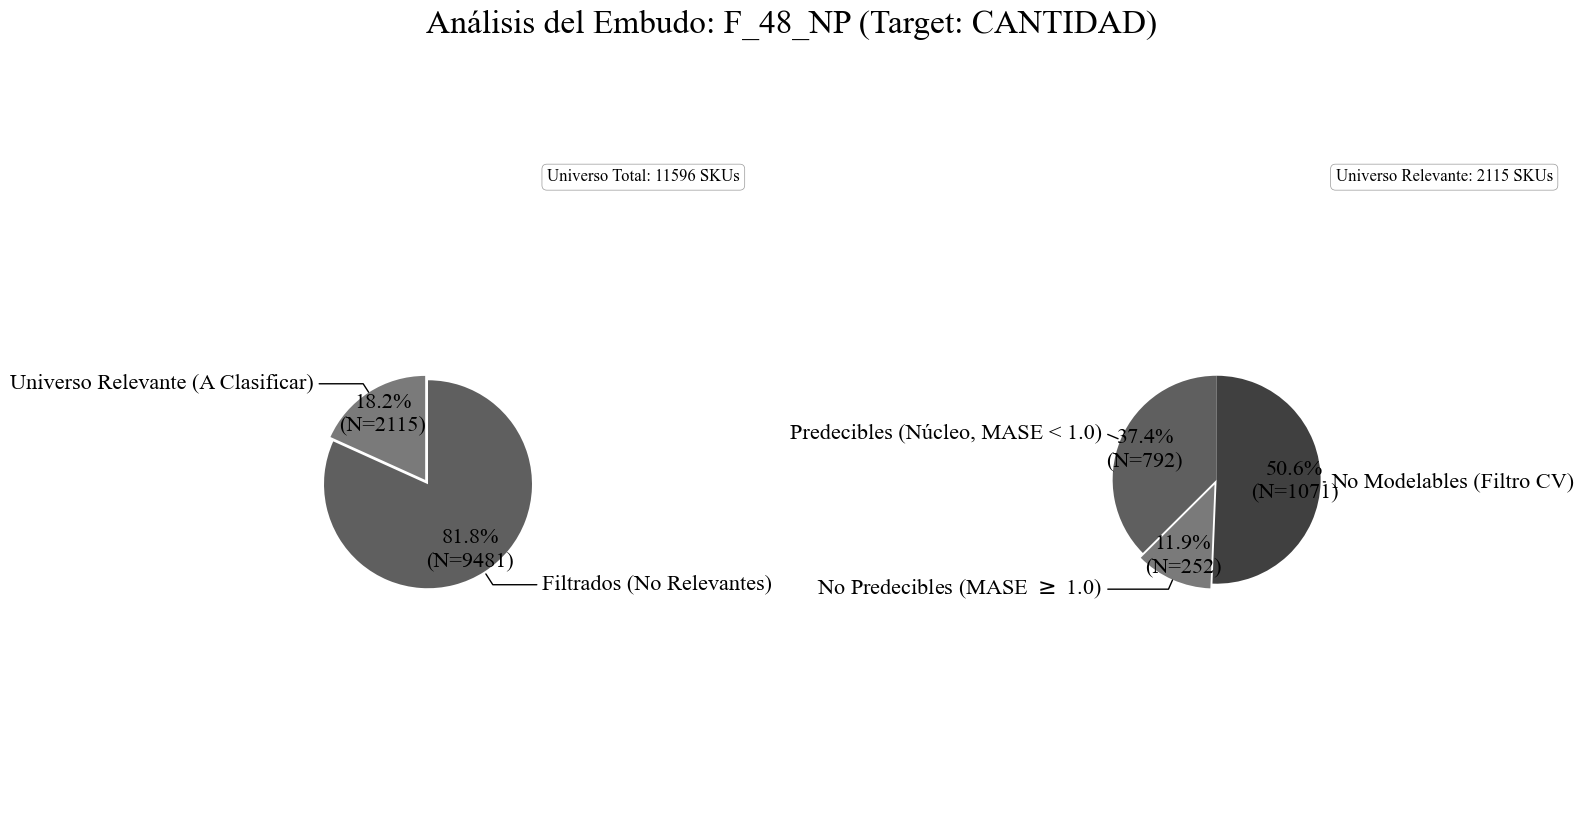

## Dashboard: F_48_NP (Target: MONTO_VENTA)



Dashboard 1x2 para 'monto_venta' guardado en: ..\04_Resultados\02_Figuras\analisis_resultados\dashboard_embudo_monto_venta_F_48_NP.png


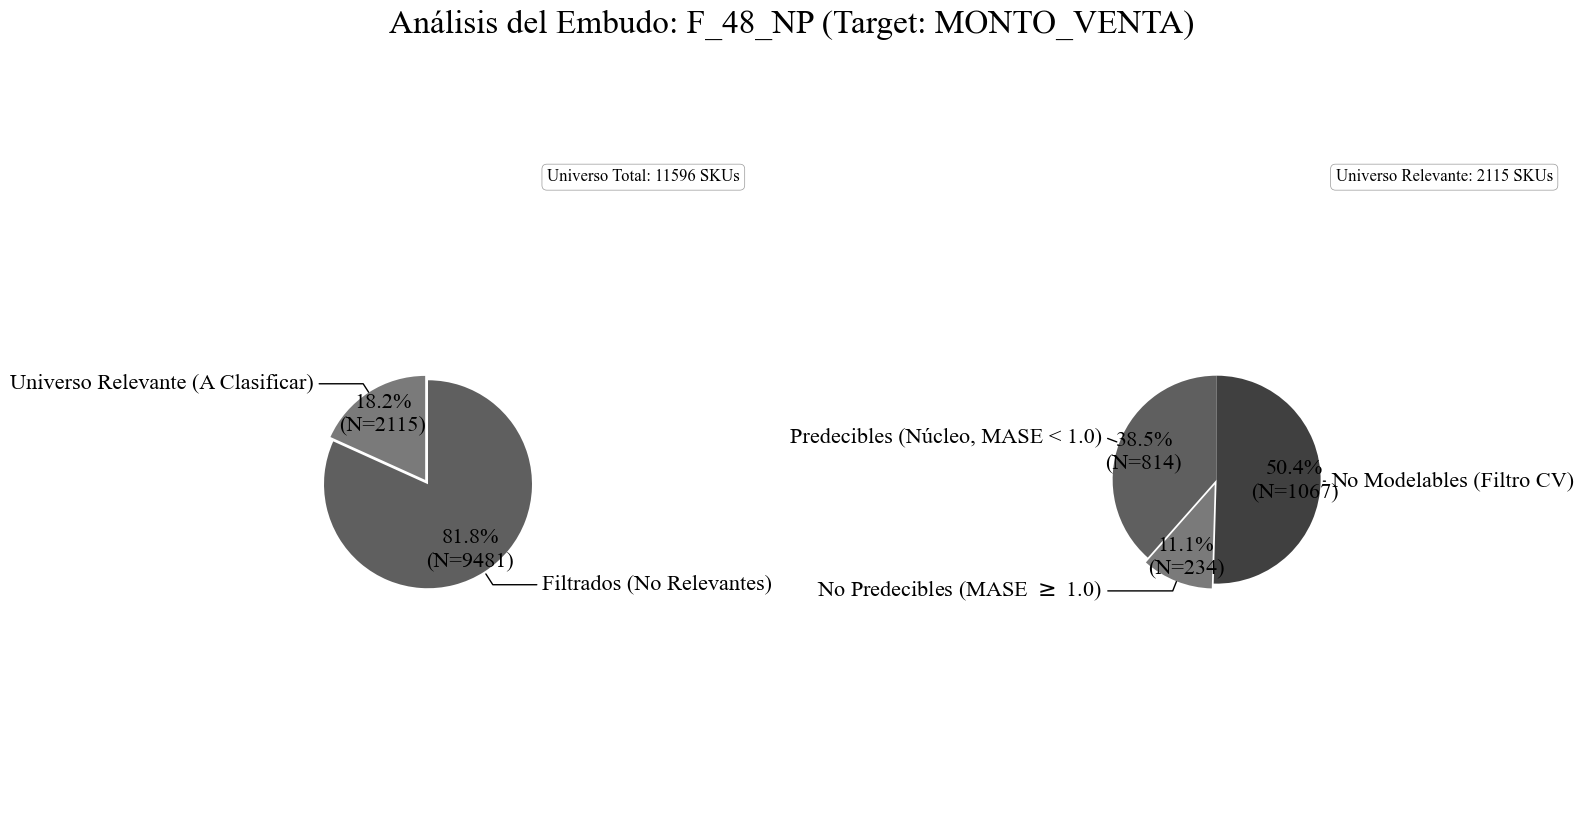

In [8]:
# =============================================================================
# CELDA 7: HUB DE VISUALIZACIÓN (Dashboard 1x2 - v20)
# =============================================================================
display(Markdown(f"# Dashboard de Resultados (Enfoque: {', '.join(datasets_to_run)})"))

# Iterar por cada target y crear un dashboard 1x2
for target in targets_a_procesar:
    
    # --- Recolectar los datos para este target ---
    dataset_name = datasets_to_run[0] # Ej: 'F_48_NP'
    if f"{target}_{dataset_name}" not in all_previsibilidad_data:
        logging.warning(f"Faltan datos de previsibilidad para '{target}'. Saltando gráficos.")
        continue
        
    # --- Datos para los 2 gráficos ---
    
    # 1. Para el Mapa del Embudo (Gráfico 1)
    total_universo_mapa = TOTAL_UNIVERSO_PRODUCTOS
    total_relevante_mapa = all_previsibilidad_data[f"{target}_{dataset_name}"]['total_relevante']

    # 2. Para el Zoom de Clasificación (Gráfico 2)
    tasa_data_zoom = all_previsibilidad_data.get(f"{target}_{dataset_name}")
    if tasa_data_zoom:
        predecibles_zoom = tasa_data_zoom['predecibles']
        no_predecibles_zoom = tasa_data_zoom['no_predecibles_modelados']
        no_modelados_cv_zoom = tasa_data_zoom['no_modelados_cv']
        total_relevante_zoom = tasa_data_zoom['total_relevante']
    else:
        predecibles_zoom, no_predecibles_zoom, no_modelados_cv_zoom, total_relevante_zoom = 0, 0, 0, 0

    
    # --- Crear el Dashboard 1x2 ---
    display(Markdown(f"## Dashboard: {dataset_name} (Target: {target.upper()})\n"))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8)) 
    fig.suptitle(f'Análisis del Embudo: {dataset_name} (Target: {target.upper()})', fontsize=24, y=1.05)

    # --- Gráfico 1: El Mapa del Embudo (ax 0) ---
    axes[0].set_title("Gráfico 1: Mapa del Embudo (Universo)", fontsize=18, pad=20)
    plot_mapa_embudo_pie(
        total_universo=total_universo_mapa,
        total_relevante=total_relevante_mapa,
        ax=axes[0],
        global_font_size=16 # <-- AUMENTADO DE 12 a 16
    )

    # --- Gráfico 2: El Zoom de Clasificación (ax 1) ---
    axes[1].set_title("Gráfico 2: Zoom de Clasificación (Relevante)", fontsize=18, pad=20)
    plot_zoom_clasificacion_pie(
        total_relevante=total_relevante_zoom,
        total_modelados_cv= (predecibles_zoom + no_predecibles_zoom),
        total_predecibles_mase=predecibles_zoom,
        total_no_predecibles_mase=no_predecibles_zoom,
        ax=axes[1],
        global_font_size=16 # <-- AUMENTADO DE 12 a 16
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Guardar el dashboard
    fig_path = os.path.join(FIGURES_OUTPUT_DIR, f'dashboard_embudo_{target}_{dataset_name}.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\nDashboard 1x2 para '{target}' guardado en: {fig_path}")
    
    plt.show()

# Análisis de Diagnóstico de Modelos (Riesgo y Ruido)

C:\Users\isaia\AppData\Local\Temp\ipykernel_34148\1234510910.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_predecibles['Risk_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)


## Diagnóstico por Modelo (Target: CANTIDAD)

,Avg_Risk_Ratio,Median_Risk_Ratio,Avg_R2_Ganador,Median_R2_Ganador
modelo_ganador_MASE,,,,
Lineal,1.23,1.22,-0.48,-0.25
KNN,1.23,1.22,-0.41,-0.23
SARIMA,1.23,1.21,-0.49,-0.20
Cuadrático,1.21,1.21,-0.31,-0.16



Tabla de Diagnóstico para 'cantidad' guardada en: ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados\resumen_diagnostico_modelos_cantidad_MASE.csv

Dashboard de Diagnóstico para 'cantidad' guardado en: ..\04_Resultados\02_Figuras\analisis_resultados\dashboard_diagnostico_cantidad_F_48_NP.png


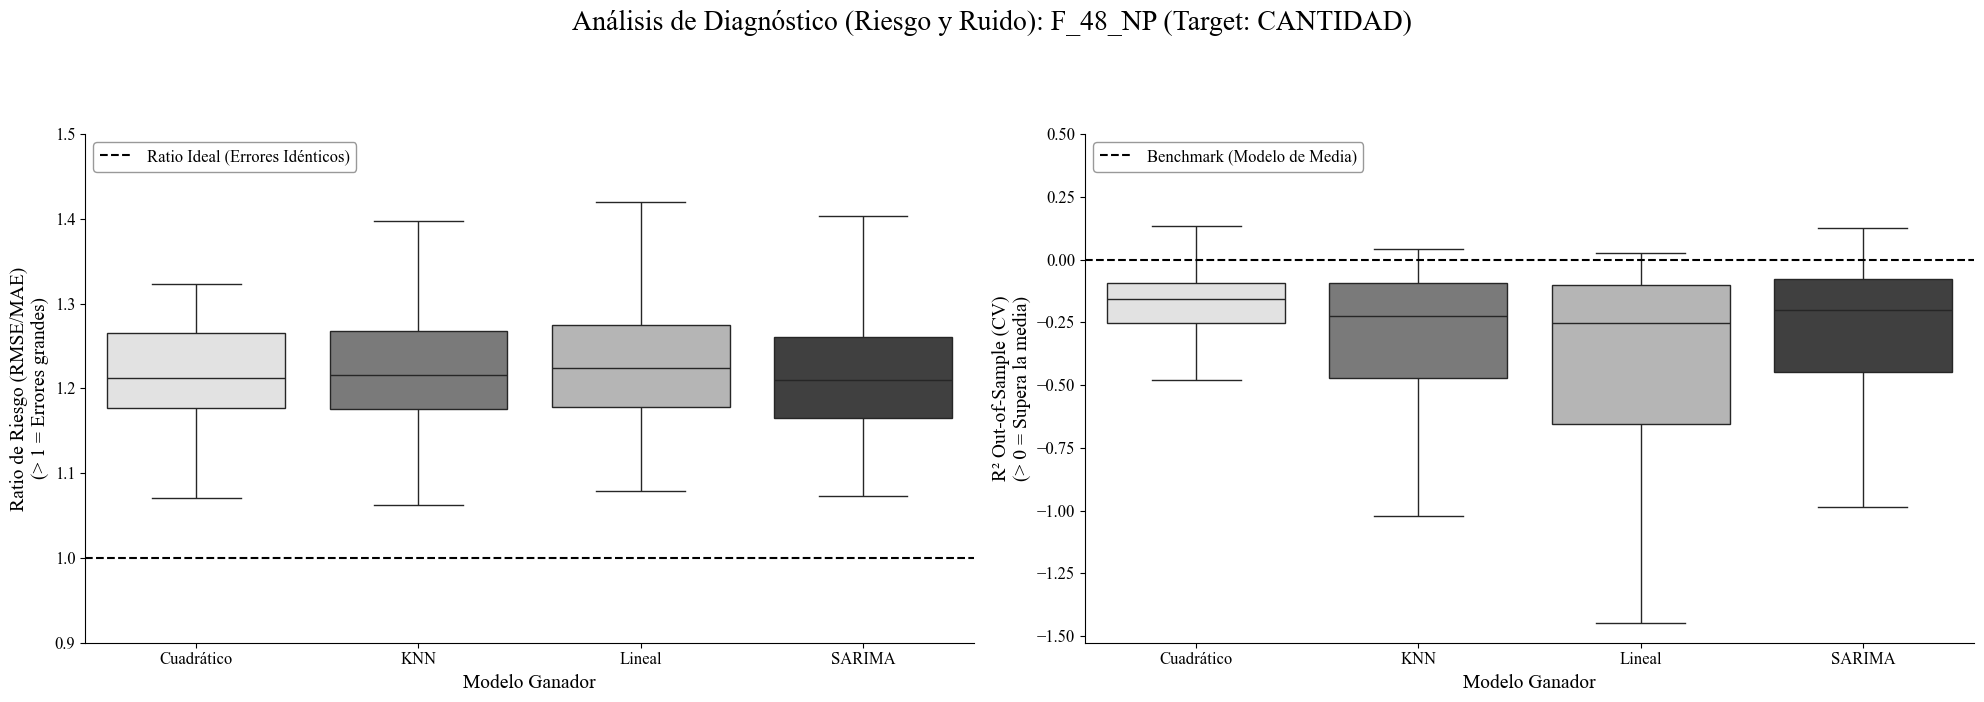

C:\Users\isaia\AppData\Local\Temp\ipykernel_34148\1234510910.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_predecibles['Risk_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)


## Diagnóstico por Modelo (Target: MONTO_VENTA)

,Avg_Risk_Ratio,Median_Risk_Ratio,Avg_R2_Ganador,Median_R2_Ganador
modelo_ganador_MASE,,,,
Cuadrático,1.24,1.22,-0.36,-0.21
KNN,1.23,1.22,-0.46,-0.28
Lineal,1.23,1.22,-0.43,-0.22
SARIMA,1.22,1.21,-0.32,-0.20



Tabla de Diagnóstico para 'monto_venta' guardada en: ..\04_Resultados\01_Tablas_Detalladas\analisis_resultados\resumen_diagnostico_modelos_monto_venta_MASE.csv

Dashboard de Diagnóstico para 'monto_venta' guardado en: ..\04_Resultados\02_Figuras\analisis_resultados\dashboard_diagnostico_monto_venta_F_48_NP.png


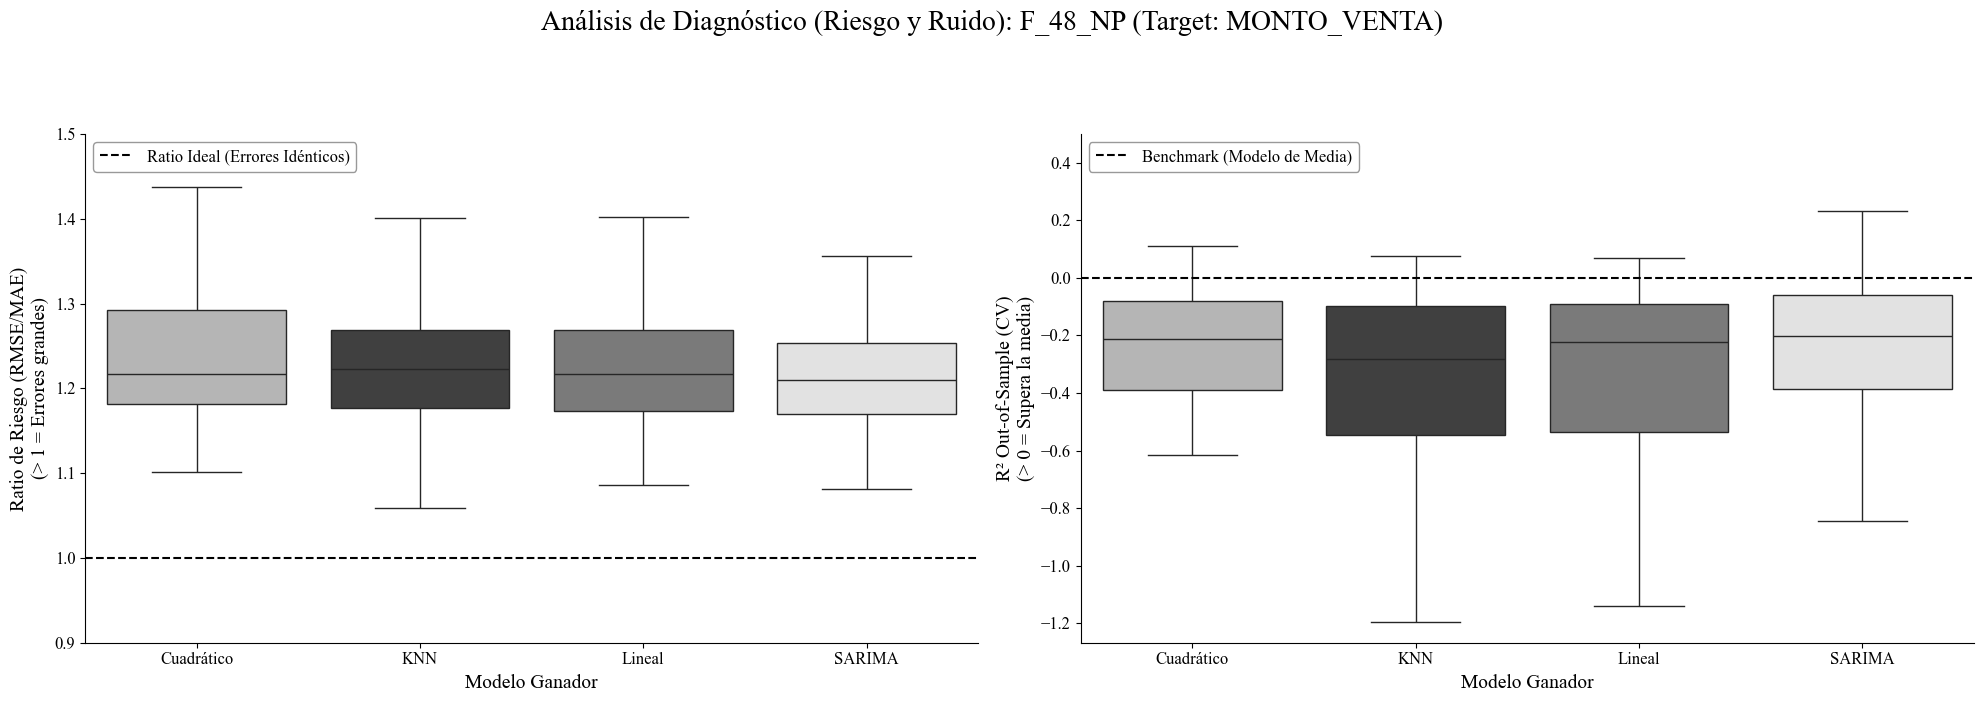

In [9]:
# =============================================================================
# ¡CELDA 8 MODIFICADA! ANÁLISIS DE DIAGNÓSTICO (RMSE/MAE y R2)
# =============================================================================
display(Markdown(f"# Análisis de Diagnóstico de Modelos (Riesgo y Ruido)"))

col_ganador = f'modelo_ganador_{MAIN_METRIC}'
col_valor_ganador = f'{MAIN_METRIC}_ganador'

for target in targets_a_procesar:
    
    if target not in all_loaded_results: continue
    dataset_name = datasets_to_run[0] # F_48_NP
    if dataset_name not in all_loaded_results[target]: continue
        
    df_full_results = all_loaded_results[target][dataset_name]
    
    # --- 1. Calcular Diagnósticos ---
    # Filtrar solo los predecibles
    df_predecibles = df_full_results[
        (df_full_results[col_valor_ganador] < METRIC_THRESHOLD)
    ].dropna(subset=[col_ganador, 'RMSE_ganador', 'MAE_ganador', 'R2_ganador'])
    
    if df_predecibles.empty:
        logging.warning(f"No hay productos predecibles para el análisis de diagnóstico en '{target}'.")
        continue

    # Calcular Ratio de Riesgo (RMSE/MAE)
    df_predecibles['Risk_Ratio'] = df_predecibles['RMSE_ganador'] / (df_predecibles['MAE_ganador'] + 1e-6)
    df_predecibles['Risk_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_predecibles.dropna(subset=['Risk_Ratio'], inplace=True)
    
    
    # --- 2. Tabla Resumen de Diagnóstico ---
    display(Markdown(f"## Diagnóstico por Modelo (Target: {target.upper()})"))
    
    df_diagnostico = df_predecibles.groupby(col_ganador).agg(
        Avg_Risk_Ratio=('Risk_Ratio', 'mean'),
        Median_Risk_Ratio=('Risk_Ratio', 'median'),
        Avg_R2_Ganador=('R2_ganador', 'mean'),
        Median_R2_Ganador=('R2_ganador', 'median')
    ).sort_values(by='Avg_Risk_Ratio', ascending=False)
    
    display(df_diagnostico.style.format("{:,.2f}").background_gradient(cmap='coolwarm', subset=['Avg_Risk_Ratio']).background_gradient(cmap='Greens', subset=['Avg_R2_Ganador']))
    
    path_diag = os.path.join(TABLES_OUTPUT_DIR, f'resumen_diagnostico_modelos_{target}_{MAIN_METRIC}.csv')
    df_diagnostico.to_csv(path_diag)
    print(f"\nTabla de Diagnóstico para '{target}' guardada en: {path_diag}")
    
    
    # --- 3. Gráficos de Diagnóstico (Risk Ratio y R2) ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 7)) # <-- ¡ACTUALIZADO A 1x2!
    fig.suptitle(f'Análisis de Diagnóstico (Riesgo y Ruido): {dataset_name} (Target: {target.upper()})', fontsize=20, y=1.03)
    
    # Gráfico 1: Risk Ratio
    plot_risk_ratio_boxplot(
        df_full_results=df_full_results,
        main_metric=MAIN_METRIC,
        threshold=METRIC_THRESHOLD,
        winning_col=col_ganador,
        ax=axes[0] # <-- Eje 0
    )
    
    # Gráfico 2: R2 Distribution
    plot_r2_distribution_boxplot(
        df_full_results=df_full_results,
        main_metric=MAIN_METRIC,
        threshold=METRIC_THRESHOLD,
        winning_col=col_ganador,
        ax=axes[1] # <-- Eje 1
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    fig_path = os.path.join(FIGURES_OUTPUT_DIR, f'dashboard_diagnostico_{target}_{dataset_name}.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\nDashboard de Diagnóstico para '{target}' guardado en: {fig_path}")
    plt.show()

In [10]:
# =============================================================================
# CELDA 9: GUARDADO DE GRÁFICOS INDIVIDUALES (PARA TESIS) - (v20 - BUCLE)
# =============================================================================
#
# Esta celda AHORA llama a las DOS funciones de torta separadas de utils.py (v19)
#
# =============================================================================

print(f"\n--- INICIANDO BUCLE DE GUARDADO DE GRÁFICOS INDIVIDUALES (v20) ---")

try:
    # --- 1. Definir la ruta de guardado ---
    TESIS_FIGS_DIR = os.path.join(RESULTS_DIR, '02_Figuras', 'tesis_graficos_individuales')
    os.makedirs(TESIS_FIGS_DIR, exist_ok=True)
    logging.info(f"Directorio de Figuras Tesis (Escritura): {TESIS_FIGS_DIR}")

    # --- 2. Definir variables constantes para el bucle ---
    dataset_name_actual = datasets_to_run[0] 
    winning_col_name = f'modelo_ganador_{MAIN_METRIC}'
    
    # --- 3. Configuración Estilo Tesis (Fuente 18pt) ---
    GLOBAL_FONT_SIZE_INDIVIDUAL = 18 # <-- AUMENTADO DE 14 a 18

    # --- 4. BUCLE PRINCIPAL DE GUARDADO ---\n",
    for target_actual in targets_a_procesar:
        print(f"\n--- Procesando Target: '{target_actual}' (Dataset: '{dataset_name_actual}') ---")

        # --- 5. Extraer datos de los diccionarios globales ---
        try:
            key_pie = f"{target_actual}_{dataset_name_actual}"
            tasa_data = all_previsibilidad_data[key_pie]
            
            # Datos para el Mapa
            total_universo_mapa = TOTAL_UNIVERSO_PRODUCTOS
            total_relevante_mapa = tasa_data['total_relevante']

            # Datos para el Zoom
            conteo_predecibles_zoom = tasa_data['predecibles']
            conteo_no_predecibles_zoom = tasa_data['no_predecibles_modelados']
            conteo_no_modelados_cv_zoom = tasa_data['no_modelados_cv']
            total_relevante_zoom = tasa_data['total_relevante']
            
            # Datos para Barcharts/Boxplots
            df_resumen_filtrado_target = all_summary_tables[target_actual]['filtrado']
            df_ganadores_plot_actual = df_resumen_filtrado_target[[dataset_name_actual]] if dataset_name_actual in df_resumen_filtrado_target.columns else pd.DataFrame()
            df_resultados_target = all_loaded_results[target_actual][dataset_name_actual]
            
        except KeyError as e:
            print(f"¡ERROR! No se encontraron datos en los diccionarios para el target '{target_actual}'. Detalle: {e}")
            continue 

        # --- 6. Llamadas a Ploteo (Standalone) ---

        # --- Gráfico 1: MAPA DEL EMBUDO (Pie) ---
        print(f"1. Guardando Mapa del Embudo (Pie) para '{target_actual}'...")
        plot_mapa_embudo_pie(
            total_universo=total_universo_mapa,
            total_relevante=total_relevante_mapa,
            ax=None,
            save_path_prefix=os.path.join(TESIS_FIGS_DIR, f'01_mapa_embudo_pie_{target_actual}'),
            global_font_size=GLOBAL_FONT_SIZE_INDIVIDUAL,
            fig_size=(7, 7)
        )

        # --- Gráfico 2: ZOOM DE CLASIFICACIÓN (Pie) ---
        print(f"2. Guardando Zoom de Clasificación (Pie) para '{target_actual}'...")
        plot_zoom_clasificacion_pie(
            total_relevante=total_relevante_zoom,
            total_modelados_cv=(conteo_predecibles_zoom + conteo_no_predecibles_zoom),
            total_predecibles_mase=conteo_predecibles_zoom,
            total_no_predecibles_mase=conteo_no_predecibles_zoom,
            ax=None,
            save_path_prefix=os.path.join(TESIS_FIGS_DIR, f'02_zoom_clasificacion_pie_{target_actual}'),
            global_font_size=GLOBAL_FONT_SIZE_INDIVIDUAL,
            fig_size=(7, 7)
        )
        
        # --- Gráfico 3: Modelos Ganadores (Bar) ---
        print(f"3. Guardando Modelos Ganadores (Bar) para '{target_actual}'...")
        plot_ganadores_barplot(
            df_ganadores_plot_actual,
            ax=None,
            save_path_prefix=os.path.join(TESIS_FIGS_DIR, f'03_ganadores_barplot_{target_actual}')
        )

        # --- Gráfico 4: Distribución MASE (Hist/Dist) ---
        print(f"4. Guardando Distribución {MAIN_METRIC} (Hist) para '{target_actual}'...")
        # --- Validar Estadísticas de MASE (Media/Mediana) [CORREGIDO] ---
        try:
            # Usar las variables en MAYÚSCULAS definidas en la Celda 2
            col_valor_ganador = f'{MAIN_METRIC}_ganador' 
            mase_values = df_resultados_target[
                (df_resultados_target[col_valor_ganador] < METRIC_THRESHOLD) 
            ][col_valor_ganador].dropna()
            
            if not mase_values.empty:
                print(f"  [Validación de Texto]: Estadísticas MASE (Target: {target_actual}):")
                print(mase_values.describe().to_string()) # Imprime la tabla de estadísticas
            else:
                print(f"  [Validación de Texto]: No hay valores MASE predecibles para {target_actual}.")
        except Exception as e:
            print(f"  [Validación de Texto]: Error al calcular describe() para MASE: {e}")
        plot_mase_distribution(
            df_resultados_target,
            MAIN_METRIC,
            METRIC_THRESHOLD,
            ax=None,
            save_path_prefix=os.path.join(TESIS_FIGS_DIR, f'04_mase_distrib_hist_{target_actual}')
        )

        # --- Gráfico 5: Sesgo (Boxplot) ---
        print(f"5. Guardando Sesgo (Boxplot) para '{target_actual}'...")
        plot_sesgo_boxplot(
            df_resultados_target,
            MAIN_METRIC,
            METRIC_THRESHOLD,
            winning_col_name,
            ax=None,
            save_path_prefix=os.path.join(TESIS_FIGS_DIR, f'05_sesgo_boxplot_{target_actual}')
        )

        # --- Gráfico 6: Risk Ratio (Boxplot) ---
        print(f"6. Guardando Risk Ratio (Boxplot) para '{target_actual}'...")
        plot_risk_ratio_boxplot(
            df_full_results=df_resultados_target,
            main_metric=MAIN_METRIC,
            threshold=METRIC_THRESHOLD,
            winning_col=winning_col_name,
            ax=None,
            save_path_prefix=os.path.join(TESIS_FIGS_DIR, f'06_risk_ratio_boxplot_{target_actual}')
        )

        # --- Gráfico 7: R² (Ruido) (Boxplot) ---
        print(f"7. Guardando R² (Ruido) (Boxplot) para '{target_actual}'...")
        plot_r2_distribution_boxplot(
            df_full_results=df_resultados_target,
            main_metric=MAIN_METRIC,
            threshold=METRIC_THRESHOLD,
            winning_col=winning_col_name,
            ax=None,
            save_path_prefix=os.path.join(TESIS_FIGS_DIR, f'07_r2_distrib_boxplot_{target_actual}')
        )
    
    print(f"\n¡Proceso completado! Se guardaron gráficos para todos los targets.")
    print(f"Revisa la carpeta: '{TESIS_FIGS_DIR}'")

except NameError as e:
    print(f"\n¡ERROR! Una variable clave no está definida (ej: 'RESULTS_DIR', 'os', 'plt').")
    print(f"Detalle del error: {e}")
    print("\n\nAsegúrate de haber ejecutado las celdas de configuración [1] a [7] (hasta 'Análisis de Sesgo').")
except Exception as e:
    print(f"\n¡Ocurrió un error inesperado!: {e}")

2025-11-11 14:35:15,151 - INFO - Directorio de Figuras Tesis (Escritura): ..\04_Resultados\02_Figuras\tesis_graficos_individuales
2025-11-11 14:35:15,331 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\01_mapa_embudo_pie_cantidad.png



--- INICIANDO BUCLE DE GUARDADO DE GRÁFICOS INDIVIDUALES (v20) ---

--- Procesando Target: 'cantidad' (Dataset: 'F_48_NP') ---
1. Guardando Mapa del Embudo (Pie) para 'cantidad'...


2025-11-11 14:35:15,530 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:15,535 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\01_mapa_embudo_pie_cantidad.eps
2025-11-11 14:35:15,738 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\02_zoom_clasificacion_pie_cantidad.png


2. Guardando Zoom de Clasificación (Pie) para 'cantidad'...


2025-11-11 14:35:15,788 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:15,798 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\02_zoom_clasificacion_pie_cantidad.eps
2025-11-11 14:35:15,975 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\03_ganadores_barplot_cantidad.png


3. Guardando Modelos Ganadores (Bar) para 'cantidad'...


2025-11-11 14:35:16,014 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:16,023 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\03_ganadores_barplot_cantidad.eps


4. Guardando Distribución MASE (Hist) para 'cantidad'...
  [Validación de Texto]: Estadísticas MASE (Target: cantidad):
count    792.000000
mean       0.727234
std        0.170930
min        0.147126
25%        0.616883
50%        0.749943
75%        0.860700
max        0.999017


2025-11-11 14:35:16,212 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\04_mase_distrib_hist_cantidad.png
2025-11-11 14:35:16,240 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:16,264 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\04_mase_distrib_hist_cantidad.eps
2025-11-11 14:35:16,438 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\05_sesgo_boxplot_cantidad.png
2025-11-11 14:35:16,474 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


5. Guardando Sesgo (Boxplot) para 'cantidad'...


2025-11-11 14:35:16,481 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\05_sesgo_boxplot_cantidad.eps
2025-11-11 14:35:16,673 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\06_risk_ratio_boxplot_cantidad.png


6. Guardando Risk Ratio (Boxplot) para 'cantidad'...


2025-11-11 14:35:16,714 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:16,720 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\06_risk_ratio_boxplot_cantidad.eps


7. Guardando R² (Ruido) (Boxplot) para 'cantidad'...


2025-11-11 14:35:16,988 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\07_r2_distrib_boxplot_cantidad.png
2025-11-11 14:35:17,029 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:17,037 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\07_r2_distrib_boxplot_cantidad.eps
2025-11-11 14:35:17,210 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\01_mapa_embudo_pie_monto_venta.png



--- Procesando Target: 'monto_venta' (Dataset: 'F_48_NP') ---
1. Guardando Mapa del Embudo (Pie) para 'monto_venta'...


2025-11-11 14:35:17,242 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:17,246 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\01_mapa_embudo_pie_monto_venta.eps


2. Guardando Zoom de Clasificación (Pie) para 'monto_venta'...


2025-11-11 14:35:17,460 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\02_zoom_clasificacion_pie_monto_venta.png
2025-11-11 14:35:17,508 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:17,513 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\02_zoom_clasificacion_pie_monto_venta.eps
2025-11-11 14:35:17,677 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\03_ganadores_barplot_monto_venta.png


3. Guardando Modelos Ganadores (Bar) para 'monto_venta'...


2025-11-11 14:35:17,717 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:17,727 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\03_ganadores_barplot_monto_venta.eps


4. Guardando Distribución MASE (Hist) para 'monto_venta'...
  [Validación de Texto]: Estadísticas MASE (Target: monto_venta):
count    814.000000
mean       0.737335
std        0.159584
min        0.197497
25%        0.638277
50%        0.752869
75%        0.857587
max        0.998867


2025-11-11 14:35:17,936 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\04_mase_distrib_hist_monto_venta.png
2025-11-11 14:35:17,974 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:18,005 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\04_mase_distrib_hist_monto_venta.eps
2025-11-11 14:35:18,189 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\05_sesgo_boxplot_monto_venta.png


5. Guardando Sesgo (Boxplot) para 'monto_venta'...


2025-11-11 14:35:18,226 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:18,233 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\05_sesgo_boxplot_monto_venta.eps
2025-11-11 14:35:18,404 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\06_risk_ratio_boxplot_monto_venta.png


6. Guardando Risk Ratio (Boxplot) para 'monto_venta'...


2025-11-11 14:35:18,443 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:18,449 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\06_risk_ratio_boxplot_monto_venta.eps
2025-11-11 14:35:18,621 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\07_r2_distrib_boxplot_monto_venta.png


7. Guardando R² (Ruido) (Boxplot) para 'monto_venta'...


2025-11-11 14:35:18,662 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-11-11 14:35:18,669 - INFO - Gráfico individual guardado en: ..\04_Resultados\02_Figuras\tesis_graficos_individuales\07_r2_distrib_boxplot_monto_venta.eps



¡Proceso completado! Se guardaron gráficos para todos los targets.
Revisa la carpeta: '..\04_Resultados\02_Figuras\tesis_graficos_individuales'
